We will start by downloading 20-newsgroup text dataset:

```http://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset```

In [41]:
import glob
import pandas as pd
import spacy
import string
from sklearn.model_selection import train_test_split
import ast
import random
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm_notebook

## Two Different Tokenization Schem

In [ ]:
'''
Only lowercase preprocessing
'''
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation
# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]
def tokenize_data(mode, pn):
    if pn == "neg":
        label = 0
    else:
        label = 1
    token_train = pd.DataFrame(columns = ["label", "content"])
    for file in glob.glob("{0}/{1}/*".format(mode, pn)):
        with open (file, 'r') as f:
            content = []
            for line in f:
                content += tokenize(line)
            token_train = token_train.append({"label": label, "content": content}, ignore_index=True)  
    return token_train
# neg_train = tokenize_data('train', 'neg')
# pos_train = tokenize_data('train', 'pos')
# neg_test = tokenize_data('test', 'neg')
# pos_test = tokenize_data('test', 'pos')

In [42]:
'''
Save the data
'''
# total_data = pd.concat([neg_train, pos_train])
# total_data['index'] = range(len(total_data))
# total_data = total_data.set_index('index')
# train_split = 0.2
# train_data, val_data = train_test_split(total_data, test_size = train_split, random_state=42)
# train_data.to_csv("new_train.csv")
# val_data.to_csv("new_val.csv")
# test_data = pd.concat([neg_test, pos_test])
# test_data['index'] = range(len(test_data))
# test_data = test_data.set_index('index')
# test_data.to_csv("new_test.csv")
train_data = pd.read_csv("new_train.csv")
val_data = pd.read_csv("new_val.csv")
test_data = pd.read_csv("new_test.csv")

In [ ]:
'''
move stop words and useless token preprocessing 
'''
tokenizer = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english')) 
stop_words.update(['\'s', '\'t'])
punctuations = string.punctuation
# lowercase and remove punctuation
def tokenize(sent):
    tokens = tokenizer(sent)
    return [token.text.lower() for token in tokens if (token.text not in punctuations)]
def tokenize_data(mode, pn):
    if pn == "neg":
        label = 0
    else:
        label = 1
    token_train = pd.DataFrame(columns = ["label", "content"])
    for file in tqdm_notebook(glob.glob("{0}/{1}/*".format(mode, pn))):
        with open (file, 'r') as f:
            content = []
            for line in f:
                new_line = re.sub(r'<br />', '', line)
                tokens = tokenize(new_line)
                tokens = [w for w in tokens if not w in stop_words] 
                content += tokens
            token_train = token_train.append({"label": label, "content": content}, ignore_index=True)  
    return token_train
# neg_train = tokenize_data('train', 'neg')
# pos_train = tokenize_data('train', 'pos')
# neg_test = tokenize_data('test', 'neg')
# pos_test = tokenize_data('test', 'pos')

In [16]:
'''
Save the data for new schem
'''
# total_data = pd.concat([neg_train, pos_train])
# total_data['index'] = range(len(total_data))
# total_data = total_data.set_index('index')
# train_split = 0.2
# train_data, val_data = train_test_split(total_data, test_size = train_split, random_state=42)
# train_data.to_csv("new_train_sche.csv")
# val_data.to_csv("new_val_sche.csv")
# test_data = pd.concat([neg_test, pos_test])
# test_data['index'] = range(len(test_data))
# test_data = test_data.set_index('index')
# test_data.to_csv("new_test_sche.csv")

# train_data = pd.read_csv("new_train_sche.csv")
# val_data= pd.read_csv("new_val_sche.csv")
# test_data = pd.read_csv("new_test_sche.csv")

In [43]:
# Split train data into actual train and validation sets
print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


## Create N-grams

In [44]:
###N-gram 
def ngrams(data, n):
    output = []
    for i in range(len(data)-n+1):
        output.append(data[i:i+n])
    return output

In [45]:
def ngrams_result(dataset, n):
    token_dataset = []
    all_token = []
    for i in dataset.index:
        gram_result = []
        for j in range(n):
            n_gram_result = ngrams(ast.literal_eval(dataset.content[i]), j+1)
            gram_result += [" ".join(n)for n in n_gram_result]
        token_dataset.append(gram_result)
        all_token += gram_result
    return token_dataset, all_token

train_data['ngram'], all_token = ngrams_result(train_data, 1)
val_data['ngram'], _= ngrams_result(val_data, 1)
test_data['ngram'], _ = ngrams_result(test_data, 1)

## Build token2id and id2token

In [66]:
from collections import Counter

max_vocab_size = 40000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_token)

In [67]:
# Lets check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))
len(id2token)

Token id 17127 ; token journalistic
Token journalistic; token id 17127


40002

In [68]:
# convert token to id in the dataset
def token2index_dataset(dataset):
    indices_data = []
    for i in dataset.index:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in dataset.ngram[i]]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data)
train_data['indices'] = train_data_indices

val_data_indices = token2index_dataset(val_data)
val_data['indices'] = val_data_indices

test_data_indices = token2index_dataset(test_data)
test_data['indices'] = test_data_indices
# val_data_indices = token2index_dataset(val_data_tokens)
# test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))
# train_data.to_csv("ngram_train.csv")
# val_data.to_csv("n_gram_val.csv")
# test_data.to_csv("n_gram_test.csv")

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


## DataLoader 

In [70]:
MAX_SENTENCE_LENGTH = 400

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data.indices, train_data.label)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset = NewsGroupDataset(val_data.indices, val_data.label)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset = NewsGroupDataset(test_data.indices, test_data.label)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)


## Model

In [71]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [72]:
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)
learning_rate = 0.001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
'''
for learning rate decay 
'''
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.99)
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        ##check if the prediction is correct and get the data
        #print(data[0], predicted[0], labels.view_as(predicted)[0])
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)



'''
validation vector for new scheme
'''
#validation_acc_sche = []
#validation_acc = []

'''
validation vector for grams 
'''
#uni_gram_acc = []
#bi_gram_acc = []
#tri_gram_acc = []
#four_gram_acc = []

'''
validatoin vector for vocabulary size
'''
#max_5000 = []
#max_10000 = uni_gram_acc
#max_20000 = []
#max_40000 = []

'''
embedding_size
'''
#embed_50 = []
#embed_100 = []
#embed_150 = []
#embed_200 = []


'''
Optimizer
'''
#sgd_acc = []
#adam_acc = []

'''
Learning Rate
'''
#lr_001 = []
#lr_0001 = []
#lr_00005 = []

'''
Learning Rate Linear Decay
'''
#lr_decay = []
# iterations = 0

'''
training_loss for learning rate 
'''
#lr_001_tr_ls = []
#lr_0001_tr_ls = []
#lr_00005_tr_ls = []
#lr_decay_ls = []

'''
training_loss for Optimizer
'''
#sgd_tr_ls = []
#adam_tr_ls = []

for epoch in range(num_epochs):
    loss_batch = 0
    for i, (data, lengths, labels) in enumerate(train_loader):        
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss_batch += loss
        loss.backward()
        optimizer.step()
        #learning rate decay
#         if i > 0 and i % 30 == 0:
#             scheduler.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            lr_decay.append(val_acc)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    #adam_tr_ls.append(loss_batch)
    

Epoch: [1/10], Step: [101/625], Validation Acc: 64.78
Epoch: [1/10], Step: [201/625], Validation Acc: 68.64
Epoch: [1/10], Step: [301/625], Validation Acc: 73.86
Epoch: [1/10], Step: [401/625], Validation Acc: 76.18
Epoch: [1/10], Step: [501/625], Validation Acc: 79.4
Epoch: [1/10], Step: [601/625], Validation Acc: 82.14
Epoch: [2/10], Step: [101/625], Validation Acc: 83.36
Epoch: [2/10], Step: [201/625], Validation Acc: 84.74
Epoch: [2/10], Step: [301/625], Validation Acc: 85.38
Epoch: [2/10], Step: [401/625], Validation Acc: 86.14
Epoch: [2/10], Step: [501/625], Validation Acc: 86.3
Epoch: [2/10], Step: [601/625], Validation Acc: 86.94
Epoch: [3/10], Step: [101/625], Validation Acc: 87.48
Epoch: [3/10], Step: [201/625], Validation Acc: 87.22
Epoch: [3/10], Step: [301/625], Validation Acc: 87.9
Epoch: [3/10], Step: [401/625], Validation Acc: 87.96
Epoch: [3/10], Step: [501/625], Validation Acc: 88.04
Epoch: [3/10], Step: [601/625], Validation Acc: 88.3
Epoch: [4/10], Step: [101/625], 

## Plots

In [ ]:
#Scheme choose
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(validation_acc))], validation_acc, label = "lower case only")
plt.plot([i+1 for i in range(len(validation_acc_sche))], validation_acc_sche, label = "lower case + remove stopwords & special token")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

In [ ]:
##Gram choose  
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(uni_gram_acc))], uni_gram_acc, label = "Unit gram")
plt.plot([i+1 for i in range(len(bi_gram_acc))], bi_gram_acc, label = "2 gram")
plt.plot([i+1 for i in range(len(tri_gram_acc))], tri_gram_acc, label = "3 gram")
plt.plot([i+1 for i in range(len(four_gram_acc))], four_gram_acc, label = "4 gram")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

In [ ]:
##Vocabular size 
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(max_5000))], max_5000, label = "5000 Vocabulary")
plt.plot([i+1 for i in range(len(max_10000))], max_10000, label = "10000 Vocabulary")
plt.plot([i+1 for i in range(len(max_20000))], max_20000, label = "20000 Vocabulary")
plt.plot([i+1 for i in range(len(max_40000))], max_40000, label = "40000 Vocabulary")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

In [ ]:
##Embedding size 
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(embed_100))], embed_100, label = "embedding size 100")
plt.plot([i+1 for i in range(len(embed_200))], embed_200, label = "embedding size 200")
plt.plot([i+1 for i in range(len(embed_150))], embed_150, label = "embedding size 150")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

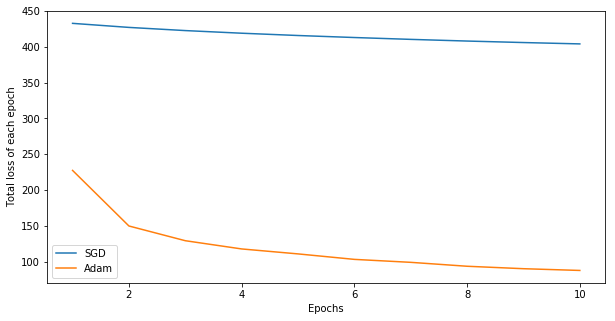

In [63]:
##Optimizaer
# plt.figure(figsize=(10,5))
# plt.plot([i+1 for i in range(len(sgd_acc))], sgd_acc, label = "SGD")
# plt.plot([i+1 for i in range(len(adam_acc))], adam_acc, label = "Adam")
# plt.xlabel("Batchs for every 100 iterations")
# plt.ylabel("Validate accuracy for every 100 iterations")
# plt.legend()
# plt.show()

plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(sgd_tr_ls))], sgd_tr_ls, label = "SGD")
plt.plot([i+1 for i in range(len(adam_tr_ls))], adam_tr_ls, label = "Adam")
plt.xlabel("Epochs")
plt.ylabel("Total loss of each epoch")
plt.legend()
plt.show()

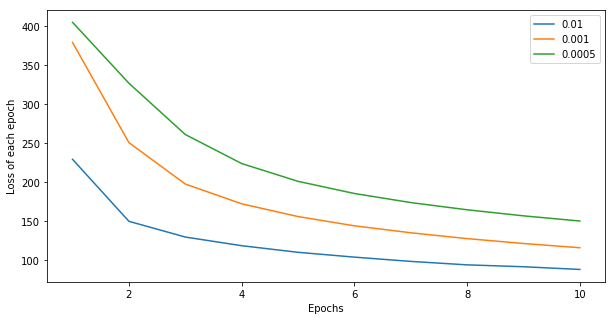

In [58]:
# Fixed learning rate and Learning rate decay
plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(lr_001))], lr_001, label = "0.01")
plt.plot([i+1 for i in range(len(lr_0001))], lr_0001, label = "0.001")
plt.plot([i+1 for i in range(len(lr_00005))], lr_00005, label = "0.0005")
plt.plot([i+1 for i in range(len(lr_decay))], lr_decay, label = "learning decay")
plt.xlabel("Batchs for every 100 iterations")
plt.ylabel("Validate accuracy for every 100 iterations")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot([i+1 for i in range(len(lr_001_tr_ls))], lr_001_tr_ls, label = "0.01")
plt.plot([i+1 for i in range(len(lr_0001_tr_ls))], lr_0001_tr_ls, label = "0.001")
plt.plot([i+1 for i in range(len(lr_00005_tr_ls))], lr_00005_tr_ls, label = "0.0005")
# plt.plot([i+1 for i in range(len(lr_decay))], lr_decay, label = "learning decay")
plt.xlabel("Epochs")
plt.ylabel("Loss of each epoch")
plt.legend()
plt.show()

## Final Model and Result

In [78]:
'''
The best model has the combination, Lower_case only, 1 gram, Vocabulary size = 40000, 
embedding_size = 100, optimizer = Adam, learning_rate = 0.001, epochs = 10
'''

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        #check if the prediction is correct and get the data
        #print(data[0], predicted[0], labels.view_as(predicted)[0])
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [76]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))
print ("Test Acc {}".format(test_model(test_loader, model)))

After training for 10 epochs
Val Acc 89.86
Test Acc 87.132


In [77]:
"""Convert token to id"""
new_dict = dict((v,k) for k,v in token2id.items())

In [80]:
def get_data(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        #check if the prediction is correct and get the data
        print(data[0], predicted[0], labels.view_as(predicted)[0])
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [81]:
test_model(val_loader, model)

tensor([    2,   947,  3641,     9,    11,    66,    45,     4,  4159,    36,
          448,   565,    18,  2754,  2873,     7,    40,  7673,    12,    10,
           29,     6,  2276,    12,    12,    15,     2,  4587,  3738,     2,
          726,    26,  4870,     3,    32,    60,    61,    74,    10,    25,
          234,    12,    10,    15,   153,     4,    19,     8,   443,    39,
            2,   152,    71,    44,   894,    70,   412,   244,    77, 20590,
            6,    31,   168,   143,     2,    21,    47,   754,     5,   398,
           21,  1291,   561,    12,     8,     7,     9,  1394,     2,  1485,
            7,    40,  3612,    12,    10,   219,    29,     6,  6546,    12,
            8,     7,     4,  1972,     5,     2,  8073,    14, 10405,    12,
            2,  3025,    68,    60,  1267,     6,    72,    10,    15,    32,
          222,  1026,    37,  1854,    66,   638,    10,   239,   185,   537,
           22,     2,     1,    56,     8,   259,     6,   533, 

            5,     2,    92,   172,     7,     4,  2003,   790,     5,   937]) tensor([1]) tensor([1])
tensor([    1,  1103,  2646,  3823,     6,    28,   215,     5,  2802,    38,
            2,   184,  1331,    25,    78,    47,  2925,   124,    38,     2,
           92,    21,   154,  4753,    28,   893,   553,     7,  1272,     6,
           30,   117,  1063,     7,     2,  5075,    28,   557,    42,    28,
          471,   255,  3734,    35, 14569, 33682,     9,     2,   205,    21,
         2802,    75,    29,     2,   173,  1331,   154,  3556,    33,     2,
           89,  1491,    29,  1707,    22,     6,    89,   190,  2802,    13,
        15739,    32,  2369,     7,   986,  2570,     9,    11,    21,    40,
          296,    27,    13,   134,  5620,   100,    14, 18170,  3963,   184,
         1331,     9,   119,    11,    21,  1103,  2802,    17,     2,    92,
         9467,   235,    32,   222,  8365,     4,     1,   241,     9,   985,
         3135,     3,  2935,   781,    

            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]) tensor([0]) tensor([0])
tensor([   10,   289,     1,  2427,    22,  1840,    17,     4,   143,     3,
           10,   422,     5,   485,     8,     2,  1859,   228,     7,     2,
          122,   109,    16,    27,   189,     6,    30,     4,   330,   228,
            2,   351,     5,     2,   108,    26,    44,   985,  2088,     5,
          184,   339,     3,   184,   321,   339,    10,    39,     6,   111,
          136,   359,   353,   104,    12,  1866,     4,   833,     5,    61,
           87,    34,    26,   219,    39,     4,   621,     5,     2,   309,
           13,  4986,     3,     1,     1,  2427,     7,    90,   164,    87,
            2,   359,   353,  7914,     9,    11,    19,    26,  3609,   345,
          528,    94,   359,   353,   104,    29,    12,   692,  4495,   496,
            3,    23,    62,   371,     2,  7914,     9,    11,    19,    71,
            2,   692, 14191,     3,  71

         5050,  2088,  5188,    18,   229,    40,   140,     2,   656,     1]) tensor([1]) tensor([1])
tensor([   10,   460,    40,    78,     6,   362,    11,    19,     8,  1707,
           54,  1355,     3,    15,    44,   365,    49,     8,    68,    80,
           22,   237,     8,    57,    29,  4532,  1202,     6,   888,   235,
          296,    50,   558,     6,     2,    66,     4,    88,   178,     3,
         4465,    71,   765,    22,     4, 13762,  6975,    49,    11,     7,
         3810,   447,    22,     2,   116,     5,     2,   159,   141,    74,
           24,    27,    82,   280,     6,    69,    12,     2,   482,   423,
           15,  1846,    98,    27,   511,     8,    32,     4, 11725,    13,
         1092,    64,   196,    29,    80,     2,  2343,     5,     4,   170,
           84, 17208,   127,   304,     2,    19,     2,   229, 28843,    20,
           17,     4,   269,    21,    25,    11,    31,   532,    17,  1895,
         1383,  4755,   873,    43,    

tensor([1207,    5,    1, 4039,    7,    4,  773, 2808,   13, 2640,    9, 6871,
          19,    8,    7,   25,    4,  188,   42, 1097, 1191,   19,  114, 3494,
           4,  579,    5, 2640,   36,   26,   45,    6,   82, 4779,   48,    5,
          70,  885, 5694, 1252,   87,   34,   62,   25,  906,    2,  846,  279,
        4779,   48,   34, 1162,    6,  347,   37,  150, 2322,  311,    2,   65,
        1939, 1590,   17,    2,   21,    7,   12,    2, 1207,  737,    1,    9,
           2,   53, 1626, 1775,  501,   48,    6,   30,   37,   48,    5,  157,
          19,  971,  255,   35,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

89.86

In [ ]:
"""
map id to token

data is in the fail_correct_data.py
"""

##Incorrect (3 example)
new = []
for i in fail1:
    new += [new_dict[i]]
print(" ".join(new), '\n')


new = []
for i in fail2:
    new += [new_dict[i]]
print(" ".join(new), '\n')

new = []
for i in fail3:
    new += [new_dict[i]]
print(" ".join(new), '\n')

##Correct(3 example)
new = []
for i in correct1:
    new += [new_dict[i]]
print(" ".join(new) + '\n')

new = []
for i in correct2:
    new += [new_dict[i]]
print(" ".join(new), '\n')

new = []
for i in correct3:
    new += [new_dict[i]]
print(" ".join(new))